In [1]:
import multiprocessing
import os
from functools import partial
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import warnings

import tensorflow as tf
from tensorflow.core.util import event_pb2

warnings.filterwarnings("ignore")

E0000 00:00:1754005969.107725 1422473 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754005969.111739 1422473 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import re

BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl"
RUNS_DIR = f"{BASE_DIR}/runs"
TABLES_DIR = f"{BASE_DIR}/results/tables/"
IMGS_DIR = f"{BASE_DIR}/results/imgs/"

THRESHOLDS = {
    "scbc-v0": 2.5e-1,
    "scbc-v1": np.exp(1),
    "scbc-v2": (1 * 160) + np.exp(1),
}

# EXP_ID = "scbc-v0-optim-L"
# EXP_ID = "scbc-v0-optim-L-60k"
# EXP_ID = "scbc-v0-homo-64L"
# EXP_ID = "scbc-v0-homo-64L-60k"

# EXP_ID = "scbc-v1-optim-L"
# EXP_ID = "scbc-v1-optim-L-60k"
# EXP_ID = "scbc-v1-homo-64L"
# EXP_ID = "scbc-v1-homo-64L-60k"

# EXP_ID = "scbc-v2-optim-L"
# EXP_ID = "scbc-v2-optim-L-60k"
# EXP_ID = "scbc-v2-homo-64L"
EXP_ID = "scbc-v2-homo-64L-60k"


def extract_version(text):
    pattern = r"(?:\b\w+-)?v\d+"
    match = re.search(pattern, text)
    return match.group(0) if match else None


THRESHOLD = THRESHOLDS[extract_version(EXP_ID)]
THRESHOLD_EPISODE = 10
NUM_STEPS = 200

EPISODE_COUNT = 60000 // NUM_STEPS
N_EXPERIMENTS = 10
TOP_K = 3

algos = ["ddpg", "dpg", "ppo", "reinforce", "sac", "td3", "trpo", "tqc", "avg"]

In [5]:
def retrieve_data(algo, ep60k):
    exp_id = EXP_ID
    if ep60k and "60k" not in EXP_ID:
        exp_id = exp_id + "-60k"
    tfrecord_paths = glob(f"{RUNS_DIR}/{exp_id}_*/*_{algo}_*/*")
    tfrecord_paths = [x for x in tfrecord_paths if "2024-06-15" not in x]
    tfrecord_paths += glob(f"{RUNS_DIR}/x9_{exp_id}_*/*_{algo}_*/*")
    cntr = 0
    data = {}
    for tfrecord_path in tfrecord_paths:
        seed = int(tfrecord_path.split("/")[-2].split("__")[-2])
        data[seed] = []
        episodic_idx = 0
        serialized_events = tf.data.TFRecordDataset(tfrecord_path)
        for serialized_example in serialized_events:
            e = event_pb2.Event.FromString(serialized_example.numpy())
            for v in e.summary.value:
                if (
                    v.HasField("simple_value")
                    and v.tag == "charts/episodic_return"
                ):
                    episodic_idx += 1
                    data[seed].append(
                        {
                            "episode": episodic_idx,
                            "episodic_return": -v.simple_value,  # Negate here to simplify later processing
                        }
                    )
        cntr += 1
    assert cntr == N_EXPERIMENTS, f"NOT OK ... {algo} ... found {cntr}"
    return data


def parallel_retrieve_data(algo, ep60k):
    return algo, retrieve_data(algo, ep60k)


def retrieve_plot_data(data, algo):
    episode_data = {}
    for seed_records in data[algo].values():
        for record in seed_records:
            episode = record["episode"]
            if episode not in episode_data:
                episode_data[episode] = []
            episode_data[episode].append(record["episodic_return"])

    episodes = sorted(episode_data.keys())
    returns = [episode_data[ep] for ep in episodes]

    means = [np.mean(x) for x in returns]
    std_devs = [np.std(x) / np.sqrt(N_EXPERIMENTS) for x in returns]

    assert (
        len(means) == len(std_devs) == EPISODE_COUNT
    ), f"EPISODES NOT OK ... {algo}"
    return episodes, returns, means, std_devs

In [6]:
with multiprocessing.Pool(processes=os.cpu_count()) as pool:
    results = pool.map(partial(parallel_retrieve_data, ep60k=False), algos)
    results_60k = pool.map(partial(parallel_retrieve_data, ep60k=True), algos)

data = {algo: result for algo, result in results}
data_60k = {algo: result for algo, result in results_60k}

data_v2 = {}
data_v2_60k = {}

for algo in algos:
    _, _, means, std_devs = retrieve_plot_data(data, algo)
    _, _, means_60k, std_devs_60k = retrieve_plot_data(data_60k, algo)
    data_v2[algo] = {"means": means, "std_devs": std_devs}
    data_v2_60k[algo] = {"means": means_60k, "std_devs": std_devs_60k}

In [7]:
def calculate_score(data, threshold):
    scores = []
    # best_algo = min(
    #     data_v2_60k.keys(), key=lambda algo: data_v2_60k[algo]["means"][-1]
    # )
    for algo, performance in data.items():
        episodes_to_threshold = next(
            (
                idx
                for idx, val in enumerate(performance["means"])
                if val <= threshold
            ),
            None,
        )
        if episodes_to_threshold is not None:
            var_after_threshold = np.mean(
                np.power(performance["std_devs"][episodes_to_threshold:], 2)
            )
            mean_at_threshold = performance["means"][episodes_to_threshold]
            diff_from_60k = -1 * (
                data_v2_60k[algo]["means"][-1] - mean_at_threshold
            )
        else:
            var_after_threshold = np.NaN
            mean_at_threshold = np.NaN
            diff_from_60k = np.NaN
        scores.append(
            {
                "algo": algo,
                "steps_to_threshold": NUM_STEPS * episodes_to_threshold
                if episodes_to_threshold is not None
                else np.NaN,
                "mean_at_threshold": -1 * mean_at_threshold,
                "var_after_threshold": var_after_threshold,
                "diff_from_60k@60k": diff_from_60k,
            }
        )
    return scores

In [8]:
import pandas as pd

df = pd.DataFrame(calculate_score(data_v2, threshold=THRESHOLD))
df = df.set_index("algo")

In [9]:
df["abs_diff_from_60k@60k"] = df["diff_from_60k@60k"].abs()

rank_metrics = [
    "steps_to_threshold",
    "var_after_threshold",
    "abs_diff_from_60k@60k",
]
ranked = df[rank_metrics].rank(ascending=True, na_option="bottom")

penalty = 10  # Fixed penalty added to the rank
mask = df["var_after_threshold"] > 3e-3
ranked.loc[mask, "var_after_threshold"] += penalty
mask = df["steps_to_threshold"] > THRESHOLD_EPISODE * NUM_STEPS
ranked.loc[mask, "var_after_threshold"] += penalty

df["final_score"] = ranked.sum(axis=1)
df.loc[df[rank_metrics].isnull().any(axis=1), "final_score"] = float("nan")
df = df.sort_values("final_score")

In [10]:
df

,steps_to_threshold,mean_at_threshold,var_after_threshold,diff_from_60k@60k,abs_diff_from_60k@60k,final_score
algo,,,,,,
ddpg,1200.0,-161.001141,0.119199,-0.433792,0.433792,15.0
td3,2000.0,-162.197484,0.065075,1.464055,1.464055,18.0
sac,4000.0,-162.631015,0.270054,0.748663,0.748663,29.0
tqc,8000.0,-162.338495,0.006413,1.904166,1.904166,30.0
dpg,11800.0,-162.428062,0.437922,0.993704,0.993704,33.0
ppo,NaN,NaN,NaN,NaN,NaN,NaN
reinforce,NaN,NaN,NaN,NaN,NaN,NaN
trpo,NaN,NaN,NaN,NaN,NaN,NaN
avg,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.to_csv(TABLES_DIR + f"{EXP_ID}.csv")

In [12]:
def format_func(value, tick_number=None):
    num_thousands = (
        0 if np.abs(value) < 1000 else int(np.floor(np.log10(abs(value)) / 3))
    )
    value = round(value / 1000**num_thousands, 2)
    txt = f"{value:g}" + " KMGTPEZY"[num_thousands]
    return txt

In [13]:
plt.rcParams.update({"font.size": 12})

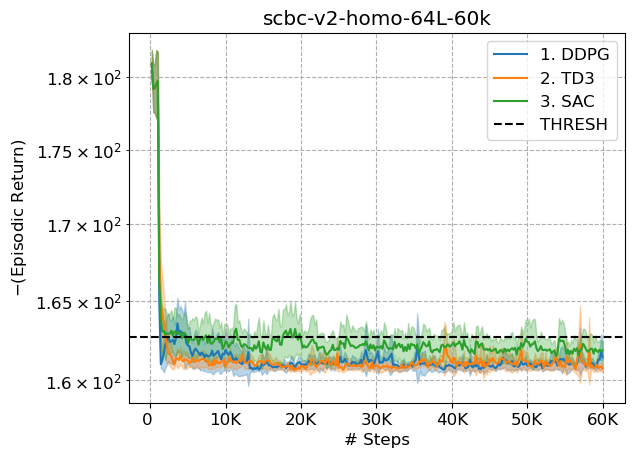

In [14]:
selected_algos = df.dropna().index.values[:TOP_K]

fig, ax = plt.subplots(figsize=(6.4, 4.8))

for idx, algo in enumerate(selected_algos):
    episodes, _, means, std_devs = retrieve_plot_data(data, algo)
    global_steps = [NUM_STEPS * x for x in episodes]
    (line,) = plt.plot(global_steps, means, label=f"{idx+1}. {algo.upper()}")
    plt.fill_between(
        global_steps,
        np.array(means) - (1.96 * np.array(std_devs)),  # 95% CI
        np.array(means) + (1.96 * np.array(std_devs)),  # 95% CI
        color=line.get_color(),
        alpha=0.3,
    )

plt.axhline(THRESHOLD, c="k", ls="--", label="THRESH")
plt.title(f"{EXP_ID}")
plt.xlabel("# Steps")
plt.ylabel("$-\mathrm{(Episodic~Return)}$")
plt.grid(True, which="both", ls="--")
plt.yscale("log")
plt.legend()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

for ext in ["pdf", "png"]:
    plt.savefig(
        f"{IMGS_DIR}/{ext}/{EXP_ID}_log10_top{TOP_K}_episodic_returns.{ext}",
        dpi=300,
        bbox_inches="tight",
    )

plt.show()